# Import the modules


In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import re
import time
import spotipy
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
import plotly
import plotly.graph_objects as go
import plotly.express as px
# connected=True means it will download the latest version of plotly javascript library.
plotly.offline.init_notebook_mode(connected=True)


# Store the Spotify Daily Hits Chart Dataset 2017- 2021 as a Dataframe
# --------------------------------------------------------------------------------------------------

In [2]:
spot = pd.read_csv(r"C:\Users\kellyc\Projects - Coding and Data Science\NYCDSA Python Data Analysis Project\charts.csv", encoding='iso-8859-1')

In [ ]:
C:\Users\kellyc\Projects - Coding and Data Science\NYCDSA Python Data Analysis Project\


# Exploring the Dataset
# ------------------------------------

In [11]:
# Taking a look at the data
spot.describe()

In [ ]:
def explore_data(dataframe):
    print('-'*100)
    print(f'The data set has {dataframe.shape[0]} rows for songs and {dataframe.shape[1]} columns for:')
    for col in dataframe.columns.tolist():
        print(col.capitalize())
    print('-'*100)
    return dataframe.dtypes

In [ ]:
explore_data(spot)

# Wrangling the Dataset 
# -----------------------------------------------------------

# Top 200 songs of 2021 in the US market

Create a function to make the Top 200 songs of 2021 in the US market Dataframe given by the number of streams

In [3]:
def create_ustop200():
    #Select the region I would like to focus on
    us_spot_200 = spot[spot['region']=='United States'][spot['chart']=='top200']

    #Convert the date column to a date from a string using datetime module
    us_spot_200['date'] = pd.to_datetime(us_spot_200['date'],format='%Y-%m-%d')

    #Adding the the song URI column Unique Identifier
    us_spot_200['URI'] = [uri.split('track/')[1] for uri in us_spot_200['url']]

    #Select a dataframe of song in 2021
    us21_t200=us_spot_200.loc[us_spot_200['date'].dt.year==2021]

    #Sort Data by number of streams to get a sense of the most popular songs
    us21_t200=us21_t200.sort_values(by=['streams'], ascending=False)
    return us21_t200



#Store Top 200 songs of 2021 in the US market to a Dataframe
#-----------------------------------------------------------
us21_t200=create_ustop200()

C:\Users\kellyc\AppData\Local\Temp/ipykernel_40208/2668432503.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



# Spotify API with spotipy
# ------------------------------------------------------------------------

# Get Spotify Credentials to access the Spotify API

In [4]:
with open(r".\C:\Users\kellyc\Projects - Coding and Data Science\NYCDSA Python Data Analysis Project\Client_info.txt") as f:
    lines = f.readlines()
    client_stuff = [line.replace('\n','').split('=')[1] for line in lines]
    f.close()
SPOTIPY_CLIENT_ID=client_stuff[0]
SPOTIPY_CLIENT_SECRET=client_stuff[1]

# Import Spotipy to access the Spotify API 

In [5]:
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

# Spotify API Code Testing
# --------------------------------------------------------------------

# Create a test dataframe to interact with the Spotify API

In [13]:
test = us21_t200.groupby('URI').agg('max').sort_values('streams', ascending=False)[['title','date','artist','streams']].reset_index()

# Testing the code to get features and the coresponding genre from the Spotify.

In [ ]:
#Find the audio features using the song url
song_features=sp.audio_features(test['URI'].iloc[3])
print(song_features[0])
print(type(song_features[0]))

#Find the artist and popularity feature using the song url 
song=sp.track(test['URI'].iloc[0])
art_id = song['album']['artists'][0]['external_urls']['spotify']
print(art_id)
print(f"This is the popluraity {song['popularity']}")


#Find the genre based on the artist
type(sp.artist(art_id)['genres'])


# Time test of genre for loop

In [ ]:
#Time test to see how long it would take to get the genres from 3 tracks
""" 
start = time.time()
genre={}
for uri in test['URI'][:3]:
    art_id = sp.track(uri)['album']['artists'][0]['external_urls']['spotify']
    genre[uri]=sp.artist(art_id)['genres']
print(time.time()-start)"""

# GENRE
# --------------------------------------------------------------------

In [ ]:
#Function gets Genre data from the Spotify API ONLY RUN ONCE 
def collect_genre(df):
    genre={}
    for uri in df['URI']:
        art_id = sp.track(uri)['album']['artists'][0]['external_urls']['spotify']
        genre[uri]=sp.artist(art_id)['genres']
    return genre

#Store genres dictionary
gen_dct = collect_genre(test)

# Original Genres

In [ ]:
"""There was an issue with the array Lengths being different that 
I didn't understand and couldn't figure out at first so I did a little work around 
to save the dictionary object to a dataframe so I could save my genre as a csv 
from a dictionary unfortunately that made my that turn my lists into strings.
After I changed the reamped the genres dictionary this issue was solve by the code below"""

# Turn genres dictionary into a dataframe
genres=pd.DataFrame({k:[v] for k,v in gen_dct.items()})
o_gen = np.transpose(genres).reset_index()
o_gen.columns=['URI','genres']

#Store genres data as a csv
o_gen.to_csv("C:\Users\kellyc\Projects - Coding and Data Science\NYCDSA Python Data Analysis Project\genre.csv", header=['URI','genres'],index = False)

# Categorical Genres

In [ ]:
"""The following code:
    1. Filters the genre dictionary into a flattend key, value pair list 
    example: {'uri':[r&b, hip hop]} ---> [['uri', r&b ],['uri','hip hop']]
    2. Creates a new expanded list of genres by filter for more common genre
    example: ['uri','canadian hip hop']]-->['uri','hip hop']]
    """
lst=[]
for key,val in gen_dct.items():
     for genre in val:
        test=re.findall(r"(pop|trap|country|hip hop|rap|adult standards|lounge|rock|r&b|edm|soul)\s*",genre)
        for new in test:
            if new in genre:
                genre=test[0]
        lst.append([key,genre])
gen_re = pd.DataFrame(lst, columns=['URI','split_genres'])

#Save genre.csv file
gen_re.to_csv("C:\Users\kellyc\Projects - Coding and Data Science\NYCDSA Python Data Analysis Project\split genre.csv", header=['URI','split_genres'],index = False)

In [ ]:
gen_re['split_genres'].value_counts()

# Song Audio Features
# -------------------------------------------------------------

### Audio Features 
Descriptions

#### acousticness 

number \<float>

A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents 
high confidence the track is acoustic.

\>= 0  
\<= 1

#### analysis_url string
A URL to access the full audio analysis of this track. An access token is required to access this data.

#### danceability

number \<float>

Danceability describes how suitable a track is for dancing based on a combination of musical 
elements including tempo, rhythm stability, beat strength, and overall regularity. 
A value of 0.0 is least danceable and 1.0 is most danceable.

#### duration_ms
integer
The duration of the track in milliseconds.

#### energy 

number \<float>

Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. 
Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, 
while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, 
perceived loudness, timbre, onset rate, and general entropy.

#### id
string
The Spotify ID for the track.

#### instrumentalness

number \<float>

Predicts whether a track contains no vocals. 
"Ooh" and "aah" sounds are treated as instrumental in this context. 
Rap or spoken word tracks are clearly "vocal". 
The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. 
Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

#### key

integer

The key the track is in. Integers map to pitches using standard Pitch Class notation. 
E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
\>= -1 <= 11

#### liveness 

number \<float>

Detects the presence of an audience in the recording. 
Higher liveness values represent an increased probability that the track was performed live. 
A value above 0.8 provides strong likelihood that the track is live.

#### loudness

number \<float>

The overall loudness of a track in decibels (dB). 
Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. 
Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). 
Values typically range between -60 and 0 db.

#### mode

integer

Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. 
Major is represented by 1 and minor is 0.

#### speechiness

number \<float>

Speechiness detects the presence of spoken words in a track. 
The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

#### tempo

number \<float>

The overall estimated tempo of a track in beats per minute (BPM). 
In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

#### time_signature

integer

An estimated time signature. 

The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).
The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".

\>= 3
\<= 7

#### track_href

string

A link to the Web API endpoint providing full details of the track.

#### type

string

The object type.

#### uri

string

The Spotify URI for the track.

#### valence

number \<float>

A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. 
Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), 
while tracks with low valence sound more negative (e.g. sad, depressed, angry).

\>= 0
\<= 1

# Create a for loop to get the features for each song

In [31]:
#Function gets genre data from the Spotify API ONLY RUN ONCE
def collect_feature(df):
    start = time.time()
    #Create of features dataframe
    features=pd.DataFrame()

    #For loop to get the features for each uri
    for uri in df['URI']:

         #Get the track features from Spotify API
        song_features=sp.audio_features(uri)
        song=sp.track(uri)
        if song_features[0] == None:
            pass
        else:
            df=song_features
            df[0]['popularity']=song['popularity']
            features=pd.concat([pd.DataFrame(df),features])
   
    # Normalize popularity
    features["popularity"] = features["popularity"] / 100.
    
    #Convert duration to mins instead of milliseconds for ease of understanding.
    features["duration_min"]=features["duration_ms"]/60000.
    
    # Normalize tempo from range tempo min to tempo max ====> min-->0.0 and max--->1.0 float
    features["tempo_norm"] = (features["tempo"]-features["tempo"].min()) / (features["tempo"].max()-features["tempo"].min())
    
    # Convert time_signature and key to category
    features["time_signature"] = features["time_signature"].astype(pd.api.types.CategoricalDtype(categories=[1, 2, 3, 4, 5]))
    features["key"] = features["key"].astype(pd.api.types.CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]))
    features["mode"] = features["mode"].astype(pd.api.types.CategoricalDtype(categories=[0, 1]))
    
    
  
    
    #Save as song_features.csv
    features.to_csv("C:\Users\kellyc\Projects - Coding and Data Science\NYCDSA Python Data Analysis Project\song_features.csv")
    print(time.time()-start)

In [32]:
features=collect_feature(test)

443.38955569267273


# -------------------------------------------------------------------------
# Data Exploration
# -------------------------------------------------------------------------

# Load genre, features, and split genre data sets.

In [151]:
#Load the Spotify API song Data stored as a csv file.
song_genre = pd.read_csv(r"C:\Users\kellyc\Projects - Coding and Data Science\NYCDSA Python Data Analysis Project\genre.csv",encoding='iso-8859-1')
song_features = pd.read_csv(r"C:\Users\kellyc\Projects - Coding and Data Science\NYCDSA Python Data Analysis Project\song_features.csv",encoding='iso-8859-1')
split_genre = pd.read_csv(r"C:\Users\kellyc\Projects - Coding and Data Science\NYCDSA Python Data Analysis Project\split genre.csv",encoding='iso-8859-1')

#Update that URI column in the features today to prepare for merging
song_features['uri']=[uri.replace('spotify:track:','')for uri in song_features['uri']]


# ------------------------------------------------------------------------
# Create Working Dataset 
# ------------------------------------------------------------------------

# Create master dataframe with genre, features, and aritist group by unique songs.

In [152]:
max_day_genre= us21_t200.groupby('URI').agg('max').sort_values('streams', ascending=False)[['title','date','artist','streams']].merge(song_genre, on='URI')
max_feat_day_genre= max_day_genre.merge(song_features, left_on='URI', right_on='id').drop(["Unnamed: 0", 'type',
 'id',
 'uri',
 'track_href',
 'analysis_url','tempo','duration_ms'],axis=1)

#Data cleaning
""""""

#Store Master data set grouped by song with features, genres, and streams.
max_feat_day_genre.to_csv("C:\Users\kellyc\Projects - Coding and Data Science\NYCDSA Python Data Analysis Project\master data set.csv",index = False)

#Load Master Dataset 
master_song_df = pd.read_csv(r"C:\Users\kellyc\Projects - Coding and Data Science\NYCDSA Python Data Analysis Project\master data set.csv",encoding='iso-8859-1')

#Convert Date into datetime format.
master_song_df['date'] = pd.to_datetime(master_song_df['date'],format='%Y-%m-%d')

# Create and save the complete categorical genre dataset

In [153]:
#Store categorical genre dataframe as a csv
c_g = master_song_df.merge(split_genre, on='URI')
c_g.to_csv("C:\Users\kellyc\Projects - Coding and Data Science\NYCDSA Python Data Analysis Project\categorical genre.csv",index = False)

#Load categorical genre Dataset 
categorical_genre  = pd.read_csv(r"C:\Users\kellyc\Projects - Coding and Data Science\NYCDSA Python Data Analysis Project\categorical genre.csv",encoding='iso-8859-1')

# Create 2021 cummulative streams by song data.

In [205]:
#Find the total number of streams for 2021 of each song on the Top 200 Hits Chart
tc2021 = us21_t200.groupby('URI')[['streams','URI']].sum('streams').reset_index().sort_values('streams', ascending=False).merge(master_song_df.drop(['streams'], axis=1), on= 'URI')

#Store cummulative genre dataframe as a csv
tc2021.to_csv(r"cummulative_streams.csv",index=False)

#Load categorical genre Dataset 
total_streams_2021  = pd.read_csv(r"C:\Users\kellyc\Projects - Coding and Data Science\NYCDSA Python Data Analysis Project\cummulative_streams.csv",encoding='iso-8859-1')

# Data Visualization
# ---------------------------------------------------------------

In [155]:
d=total_streams_2021[['URI','streams','artist','title']].groupby('artist').max().sort_values('streams',ascending=False).reset_index().head(10)
fig = px.bar(d, y='streams', x='artist',text ='streams', hover_data=['streams'], color='streams',labels={'artist':'Artist','streams':'Total Stream for 2021'}, orientation = 'v',title='Top 10 Streaming Artists on Spotify in 2021')
fig.show()

# Top 10 by Streaming on Spotify's Daily Hits 2021 

# Year: 2021

In [229]:
top_10_songs=total_streams_2021[['URI','streams','artist','title']].groupby('URI').max().sort_values('streams',ascending=False).reset_index().head(10)
fig = px.bar(top_10_songs, x='streams', y='title',text ='artist', hover_data=['streams'],color = 'streams',labels={'title':'Song Titles','streams':'Total Stream for 2021'}, 
             height=400, orientation = 'h',title='Top 10 Streaming Songs on Spotify in 2021')
fig.show()

# Monthly

In [141]:
us21_t200['month'] = pd.DatetimeIndex(us21_t200['date']).month_name()
df=us21_t200[['URI','streams','artist','title','month']].groupby([us21_t200['date'].dt.month,'month']).sum().reset_index()
fig = px.bar(df, y='streams', x='month', color="month",
             labels={'title':'Song Titles','streams':'Total Monthly Streams for 2021','month':"Months"},
             height=400, title='Total Monthly Streams for 2021')
fig.show()

# Top by Appreance on Daily Hits 2021

Text(0.5, 1.0, 'Top 10 Artists on Daily Hits 2021')

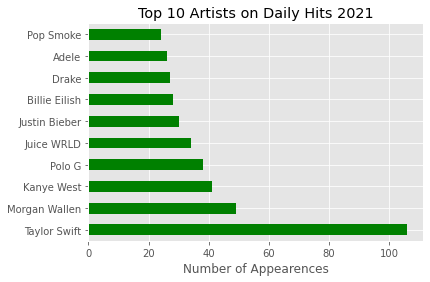

In [158]:
master_song_df['artist'].value_counts().head(10).plot.barh(color='green')

plt.xlabel('Number of Appearences')
plt.title('Top 10 Artists on Daily Hits 2021')

# Top 10 Genres streamed on Daily Hits 2021

Text(0.5, 1.0, 'Number of Songs vs Genre')

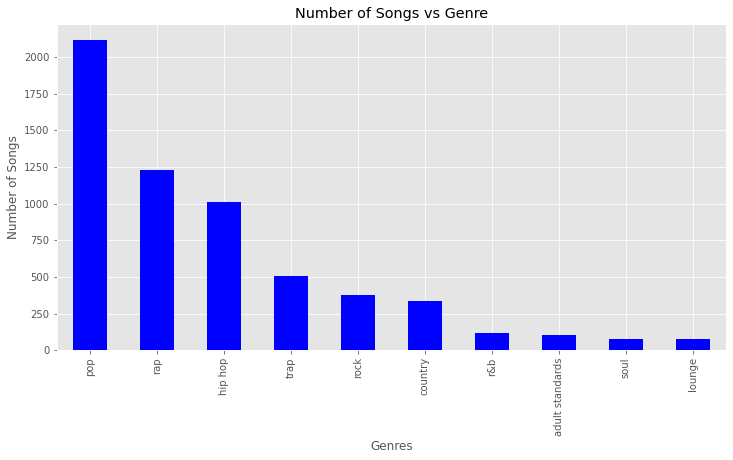

In [159]:
d=categorical_genre[['split_genres']].value_counts().reset_index().head(10)
d.columns=['Genres','G_count']
plt.figure(figsize = (12,6))
d.groupby('Genres')['G_count'].median().sort_values(ascending = False).plot.bar(color = 'blue')
plt.ylabel('Number of Songs')
plt.title('Number of Songs vs Genre')

# Sub Genre Exploration
# ---------------------------------

In [404]:
df =categorical_genre.loc[categorical_genre['split_genres']=='pop'].groupby('genres').agg('sum').sort_values('streams',ascending=False).head(10).reset_index()
fig=px.histogram(df, x='streams', y='genres', hover_data=['genres'],color = 'streams', 
             height=400,title='Top 10 Pop Genres in 2021')
fig.update_xaxes(title_text="Number of Streams")
fig.update_yaxes(title_text="Sub-Genres")

In [396]:
df =categorical_genre.loc[categorical_genre['split_genres']=='rap'].groupby('genres').agg(sum).sort_values('streams',ascending=False).head(10).reset_index()
fig=px.histogram(df, x='streams', y='genres', hover_data=['genres'],
             height=400, orientation = 'h',title='Top 10 Rap Genres in 2021')
fig.update_xaxes(title_text="Number of Streams")
fig.update_yaxes(title_text="Sub-Genres")

In [399]:
df =categorical_genre.loc[categorical_genre['split_genres']=='hip hop'].groupby('genres').agg('sum').sort_values('streams',ascending=False).head(10).reset_index()
fig=px.histogram(df, x='streams', y='genres', hover_data=['genres'],color = 'streams', 
             height=400, orientation = 'h',title='Top 10 Hip Hop Genres in 2021')
fig.update_xaxes(title_text="Number of Streams")
fig.update_yaxes(title_text="Sub-Genres")

# -----------------------------------------------------------------------------
# Exploratory Data Analysis
# -----------------------------------------------------------------------------

#  Streams vs Popularity

Text(0.5, 0.98, 'Streams vs Popularity')

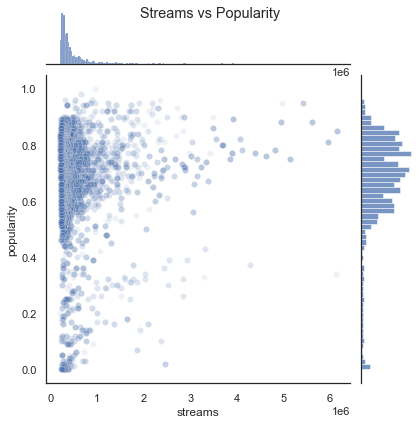

In [212]:
sns.jointplot(y=categorical_genre['popularity'],x=categorical_genre['streams'],alpha=.09, color='b')
plt.suptitle('Streams vs Popularity')

# Triangular Heatmap of all Audio Features including Popularity

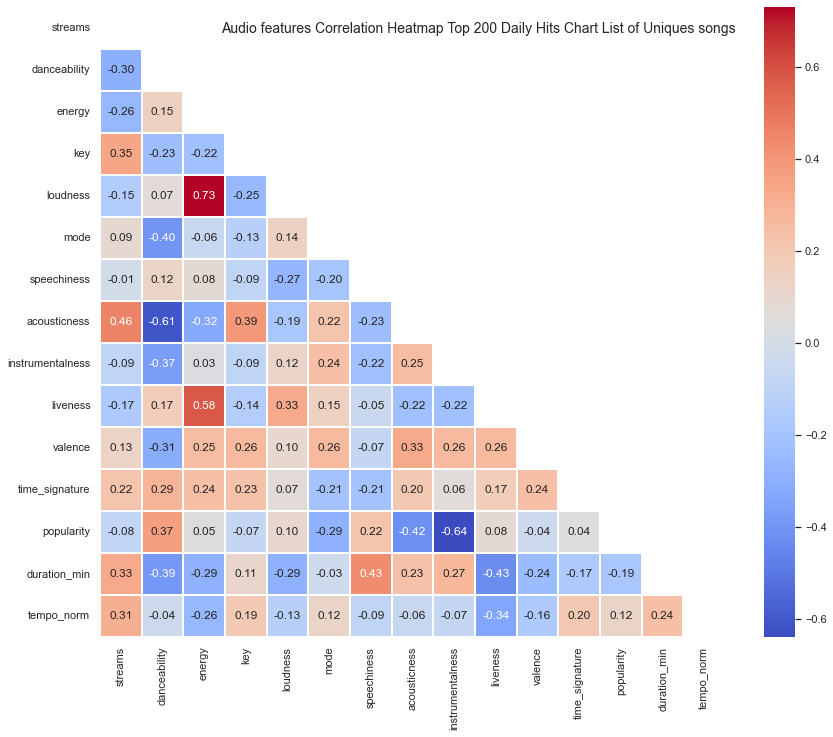

In [235]:
# Correlation Matrix Heatmap by song for the 2248 uniques songs on each of the Top 200 daily hits list in 2021
f, ax = plt.subplots(figsize=(14, 10))
corr = master_song_df.groupby('URI').max().sort_values('streams',ascending=False).head(20).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

hm = sns.heatmap(round(corr,2),mask=mask, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=1)
t= f.suptitle('Audio features Correlation Heatmap Top 200 Daily Hits Chart List of Uniques songs', fontsize=14)

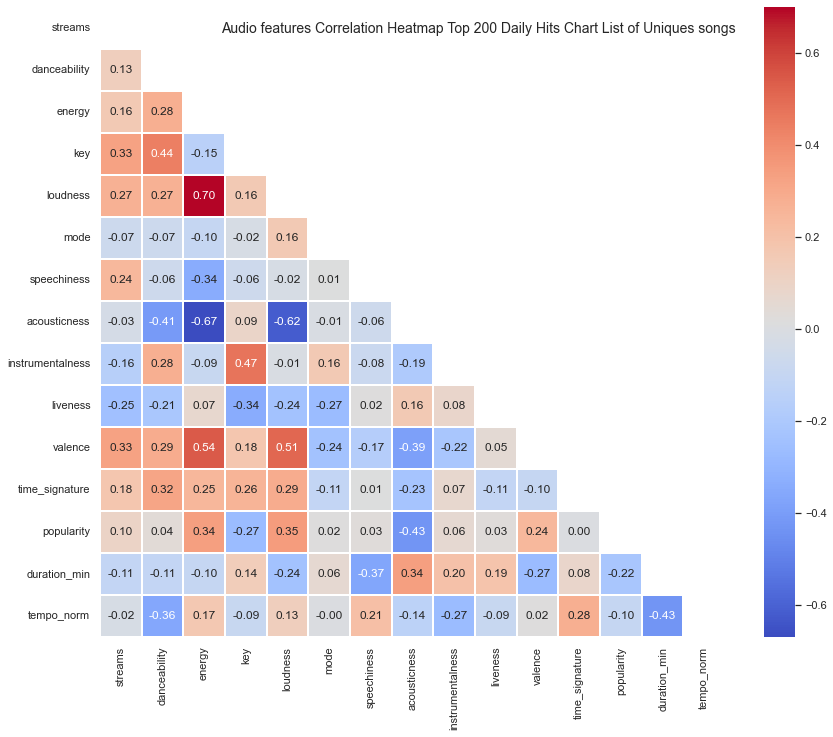

In [234]:
# Correlation Matrix Heatmap by song for the 2248 uniques songs on each of the Top 200 daily hits list in 2021
f, ax = plt.subplots(figsize=(14, 10))
corr = total_streams_2021.groupby('URI').max().sort_values('streams',ascending=False).head(20).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

hm = sns.heatmap(round(corr,2),mask=mask, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=1)
t= f.suptitle('Audio features Correlation Heatmap Top 200 Daily Hits Chart List of Uniques songs', fontsize=14)

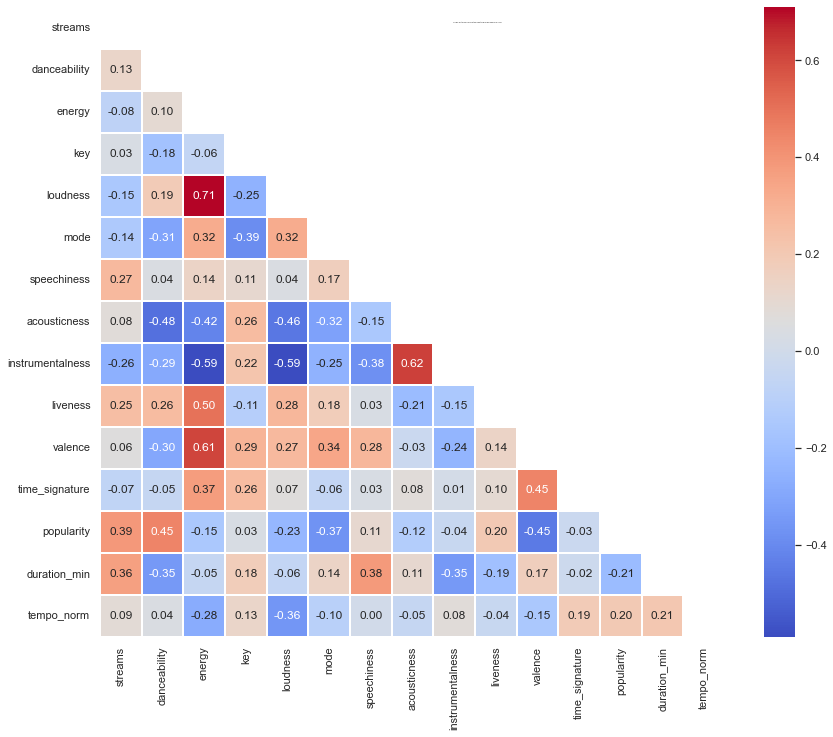

In [380]:
# Correlation Matrix Heatmap by Rap Songs
f, ax = plt.subplots(figsize=(14, 10))
corr = categorical_genre.loc[categorical_genre['split_genres']=='rap'].sort_values('streams',ascending=False).head(50).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

hm = sns.heatmap(round(corr,2),mask=mask, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=1)
t= f.suptitle('Audio features Correlation Heatmap Rap Genre in 2021', fontsize=2)

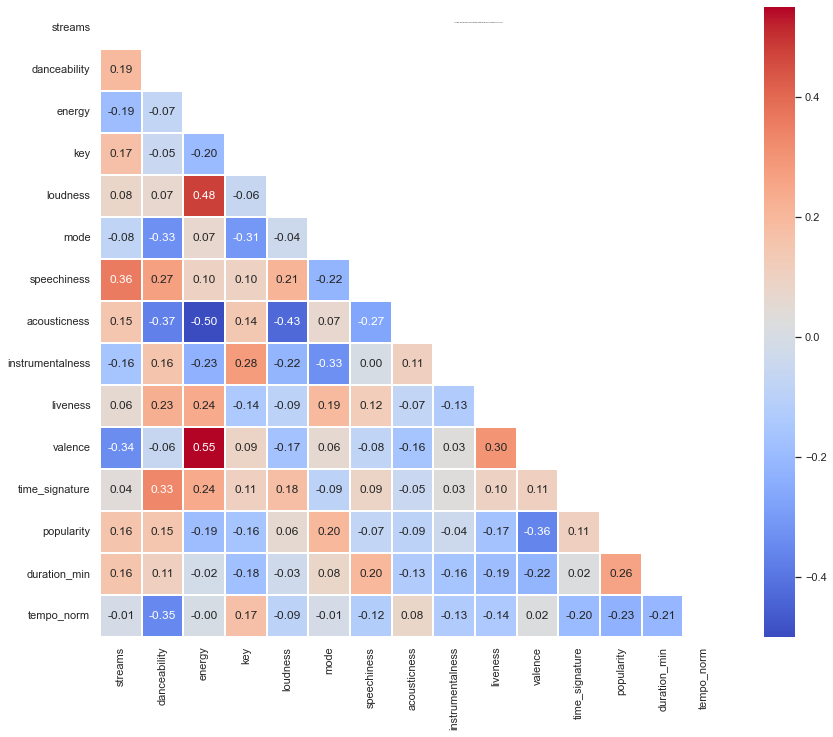

In [381]:
# Correlation Matrix Heatmap by Pop Songs
f, ax = plt.subplots(figsize=(14, 10))
corr = categorical_genre.loc[categorical_genre['split_genres']=='pop'].sort_values('streams',ascending=False).head(50).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

hm = sns.heatmap(round(corr,2),mask=mask, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=1)
t= f.suptitle('Audio features Correlation Heatmap Pop Genre in 2021', fontsize=2)

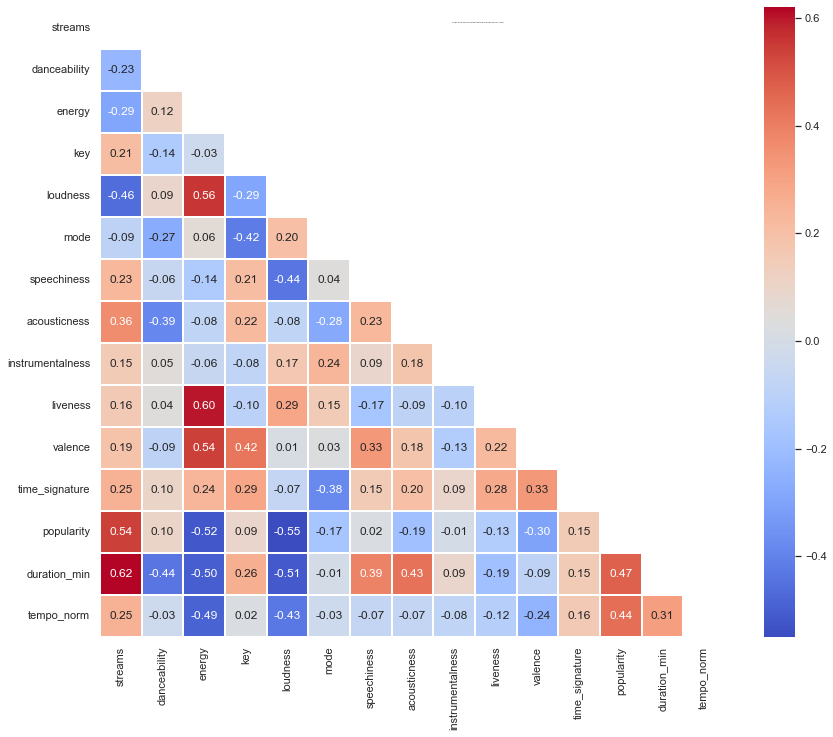

In [382]:
# Correlation Matrix Heatmap by Rap Songs
f, ax = plt.subplots(figsize=(14, 10))
corr = categorical_genre.loc[categorical_genre['split_genres']=='hip hop'].sort_values('streams',ascending=False).head(50).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

hm = sns.heatmap(round(corr,2),mask=mask, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=1)
t= f.suptitle('Audio features Correlation Heatmap Hip Hop Genre in 2021', fontsize=2)

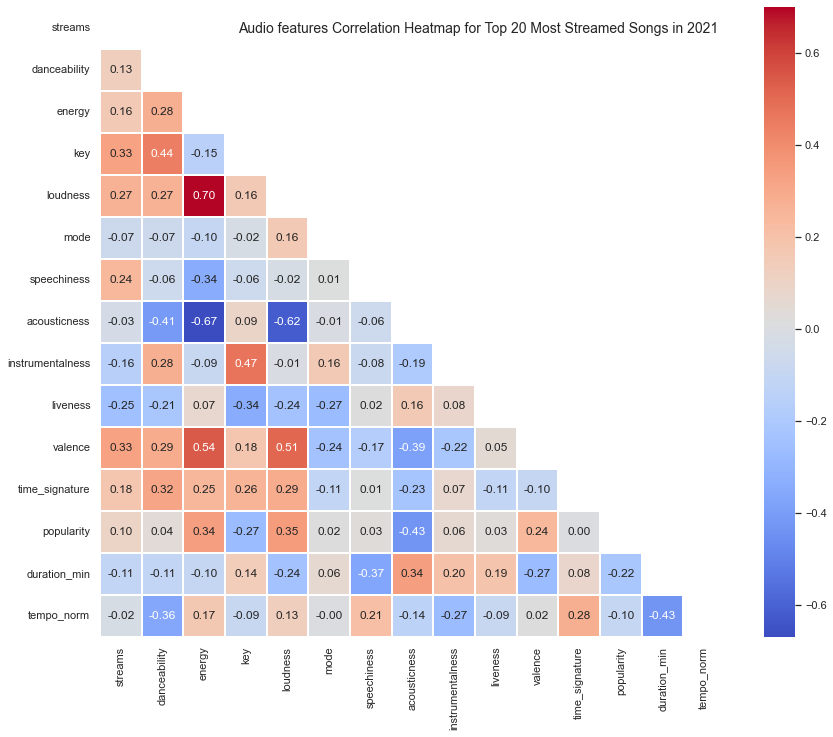

In [214]:
# Correlation Matrix Heatmap by song 
f, ax = plt.subplots(figsize=(14, 10))
corr = total_streams_2021.sort_values('streams',ascending=False).head(20).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

hm = sns.heatmap(round(corr,2),mask=mask, annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=1)
t= f.suptitle('Audio features Correlation Heatmap for Top 20 Most Streamed Songs in 2021', fontsize=14)

# ------------------------------------------------------------------------------
# Contour Maps of Two Features
# ------------------------------------------------------------------------------

In [241]:
fig = px.density_contour(master_song_df, x='liveness', y="valence", marginal_x="histogram", marginal_y="histogram")
fig.update_xaxes(title_text="liveness")
fig.update_yaxes(title_text="valence")
fig.show()

In [242]:

fig = go.Figure(go.Histogram2dContour(
        x = master_song_df['popularity'],
        y = master_song_df["danceability"],
        colorscale = 'Blues'
)
,layout_title_text="Danceability vs Popularity")
fig.update_xaxes(title_text="Popularity")
fig.update_yaxes(title_text="Danceability")

In [243]:
fig = go.Figure(go.Histogram2dContour(
        x = master_song_df['streams'],
        y = master_song_df["danceability"],
        colorscale = 'Reds'
)
,layout_title_text="Danceability vs Streams")
fig.update_xaxes(title_text="Streams")
fig.update_yaxes(title_text="Danceability")

In [244]:
fig = go.Figure(go.Histogram2dContour(
        x = master_song_df['streams'],
        y = master_song_df["danceability"],
        colorscale = 'Reds'
)
,layout_title_text="Danceability vs Streams")
fig.update_xaxes(title_text="Streams")
fig.update_yaxes(title_text="Danceability")

In [259]:
categorical_genre.columns

Index(['URI', 'title', 'date', 'artist', 'streams', 'genres', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'time_signature',
       'popularity', 'duration_min', 'tempo_norm', 'split_genres'],
      dtype='object')

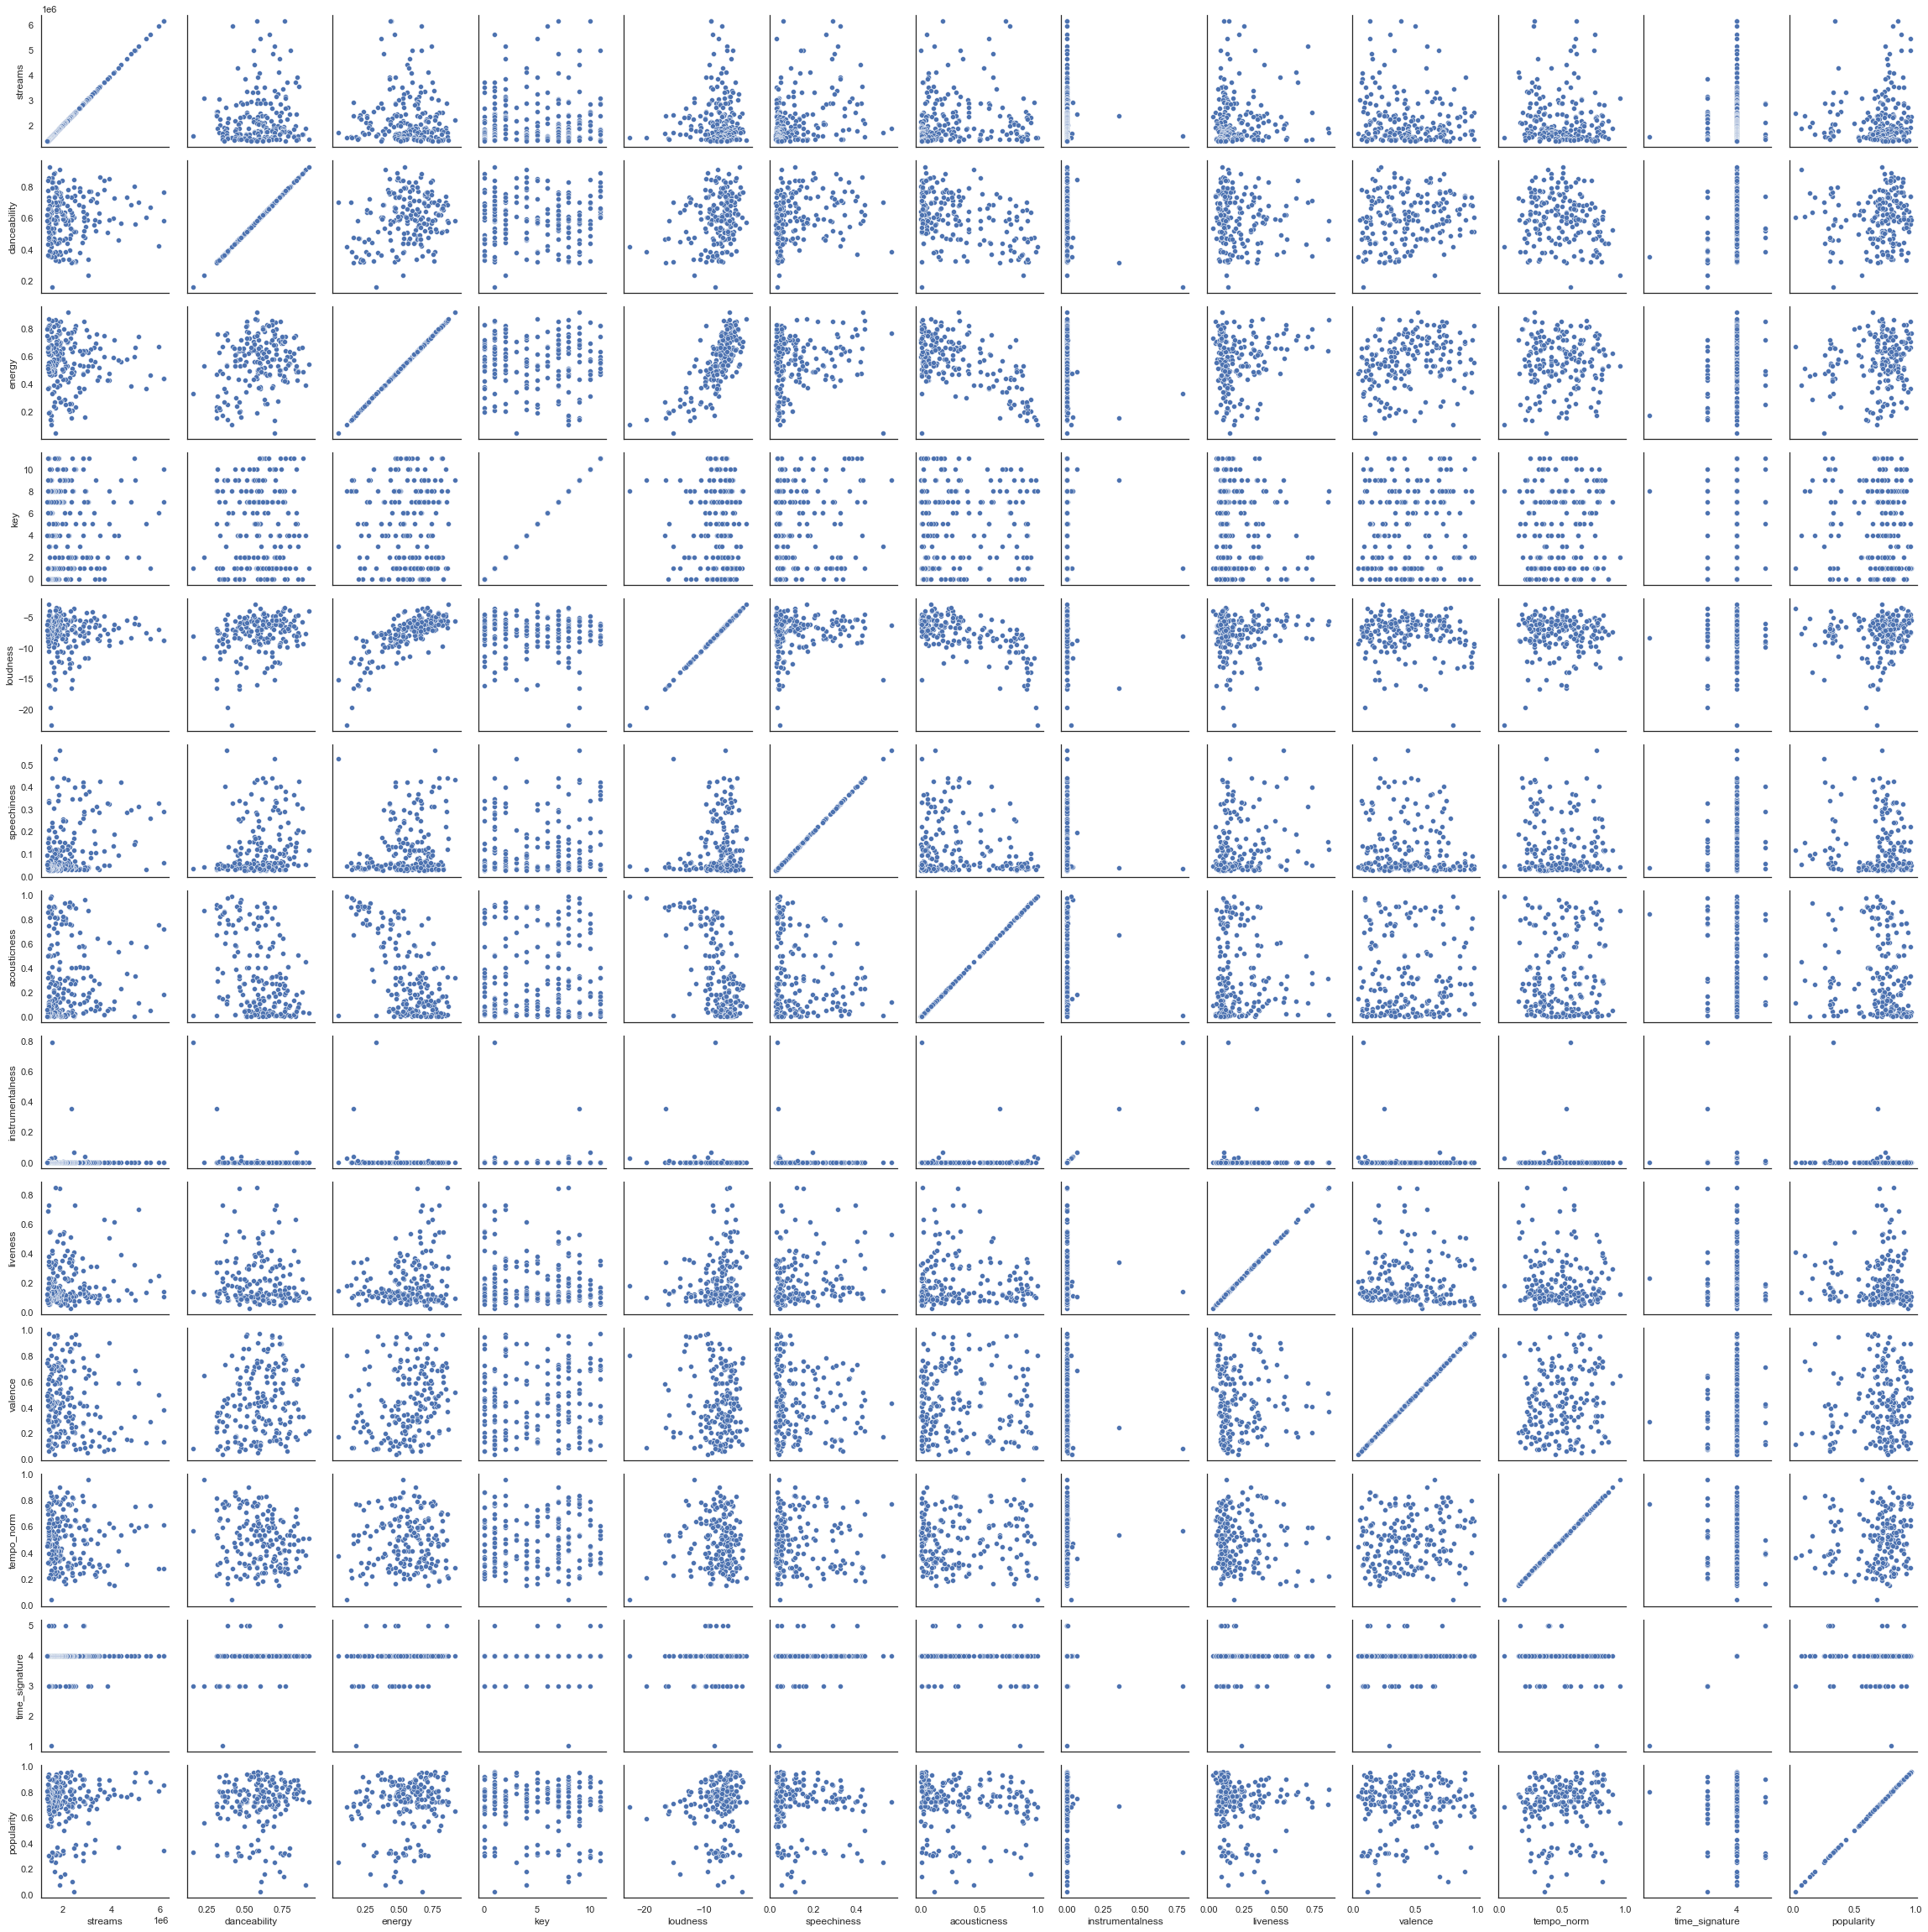

In [238]:
g = sns.PairGrid(master_song_df[['streams', 'danceability',
       'energy', 'key', 'loudness','speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo_norm',
       'time_signature', 'popularity']].head(200))
g.map(sns.scatterplot)

In [361]:
audio_feat_gerne_weighted = categorical_genre[['split_genres','streams']].groupby(['split_genres']).agg('sum').sort_values(['streams'],ascending=False).reset_index().head(10)

audio_feat_gerne_weighted


,split_genres,streams
0,pop,1.268144e+09
1,rap,8.411088e+08
2,hip hop,6.948405e+08
3,trap,2.088023e+08
4,rock,1.665006e+08
5,country,1.241529e+08
6,adult standards,9.665715e+07
7,lounge,7.079203e+07
8,soul,5.856034e+07
9,r&b,5.614594e+07


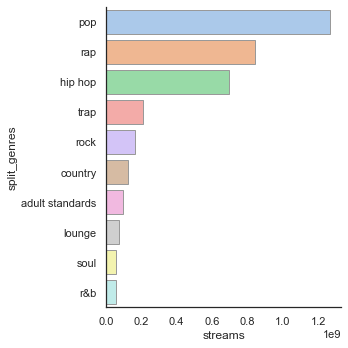

In [363]:
sns.catplot(x='streams' ,y="split_genres", kind="bar",
            palette="pastel", edgecolor=".6",
            data=audio_feat_gerne_weighted)